In [120]:
import pandas as pd
import random
import numpy as np
from ucimlrepo import fetch_ucirepo 

from sklearn.linear_model import LogisticRegression
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

import matplotlib.pyplot as plt

In [121]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 


In [122]:
def get_back_original_data(df):
    """_summary_

    Retransforme les données originales de bike sharing. D'après la documentation 

    Args:
        df (Pandas): Data bike_rental
    """

    temp = df.copy()
    #Température
    temp['temp_original'] = temp['temp'] * (39 - (-8)) + (-8)

    # Température ressentie
    temp['atemp_original'] = temp['atemp'] * (50 - (-16)) + (-16)

    # Humidité
    temp['hum_original'] = temp['hum'] * 100

    # Vitesse du vent
    temp['windspeed_original'] = temp['windspeed'] * 67

    temp = temp.drop(["temp",'atemp','hum','windspeed'],axis=1)

    # Renommer les colonnes pour retirer '_original'
    temp.rename(columns={
        'temp_original': 'temp',
        'atemp_original': 'atemp',
        'hum_original': 'hum',
        'windspeed_original': 'windspeed'
    }, inplace=True)
        
    return(temp)

In [123]:
X_original = get_back_original_data(X)

### Bike sharing demand

Ce jeu de données regroupe la demande journalière de vélo en location.

#### Columns descrbibe 
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter  
    holiday - whether the day is considered a holiday  
    workingday - whether the day is neither a weekend nor holiday  
- weather -
1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

## Exploration du dataset  

In [5]:
X_original.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,3.28,3.0014,81.0,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,2.34,1.9982,80.0,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,2.34,1.9982,80.0,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,3.28,3.0014,75.0,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,3.28,3.0014,75.0,0.0


In [124]:
#One hot encoding des catégories
season_cat = pd.get_dummies(X_original.season, prefix="season")
weathersit_cat = pd.get_dummies(X_original.weathersit, prefix="weathersit")

X_train = pd.concat([X_original, season_cat, weathersit_cat], axis=1)\
            .query("weathersit!=4")\
            .drop(["season","dteday","weathersit"],axis=1)


y_train = y[X_original.weathersit!=4]


In [125]:
# tous les colonnes
features_names = X_train.columns

# Seulement les catégorielels

feature_category = X_train.select_dtypes('uint8').columns

# Les continues

feature_quanti = X_train.select_dtypes(exclude='uint8').columns

### Train model

In [126]:
# Init random forest class
rf = RandomForestRegressor(   n_estimators=250)

In [9]:
rf.fit(X_train, y_train)

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=250)

In [10]:
mean_squared_error(rf.predict(X_train), y_train, squared=False)

15.424452524582115

### Interprétation classique


In [10]:
from sklearn.linear_model import LinearRegression

array([[<Axes: title={'center': 'cnt'}>]], dtype=object)

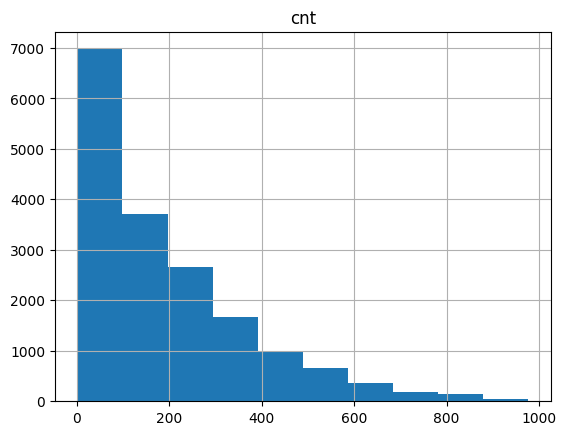

In [127]:
y.hist()

In [128]:
lr = LinearRegression()
lr.fit(X.drop('dteday',axis=1), y)

LinearRegression()

In [12]:
print(pd.DataFrame(np.abs(lr.coef_[0]),index=X.drop('dteday',axis=1).columns,columns=['abs(coef)']))
print('-------------------------------------------')
print(pd.DataFrame(lr.coef_[0],index=X.drop('dteday',axis=1).columns,columns=['coef']))
print('-------------------------------------------')
print(mean_squared_error(lr.predict(X.drop('dteday',axis=1)), y, squared=False))

#La valeur avec le plus d'impact c'est yr car elle possède le plus haut coéfficient.
#Problème coéfficient pas à la même échelle il faudrait centrer réduire

             abs(coef)
season       19.899338
yr           81.087156
mnth          0.008648
hr            7.670597
holiday      21.879216
weekday       1.878354
workingday    3.939225
weathersit    3.432098
temp         78.149780
atemp       233.157087
hum         198.184681
windspeed    41.565215
-------------------------------------------
                  coef
season       19.899338
yr           81.087156
mnth         -0.008648
hr            7.670597
holiday     -21.879216
weekday       1.878354
workingday    3.939225
weathersit   -3.432098
temp         78.149780
atemp       233.157087
hum        -198.184681
windspeed    41.565215
-------------------------------------------
141.79666742505952


In [13]:
from sklearn.metrics import r2_score
r2_score(y,lr.predict(X.drop('dteday',axis=1)))

0.38885839063003313

## Partial dependence plot

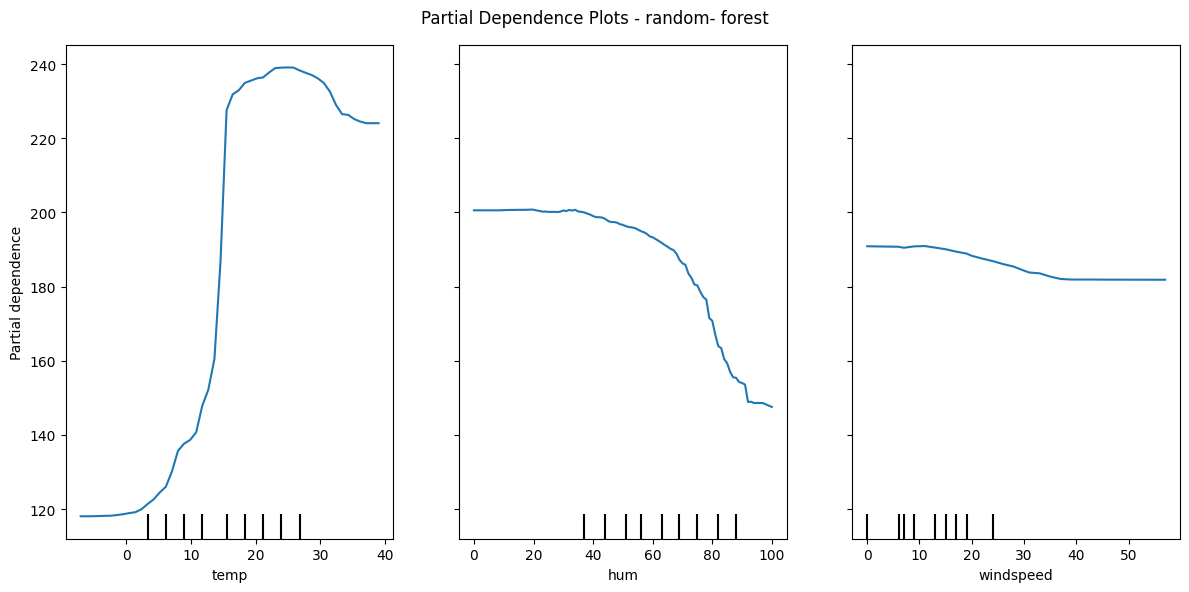

In [29]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum","windspeed"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

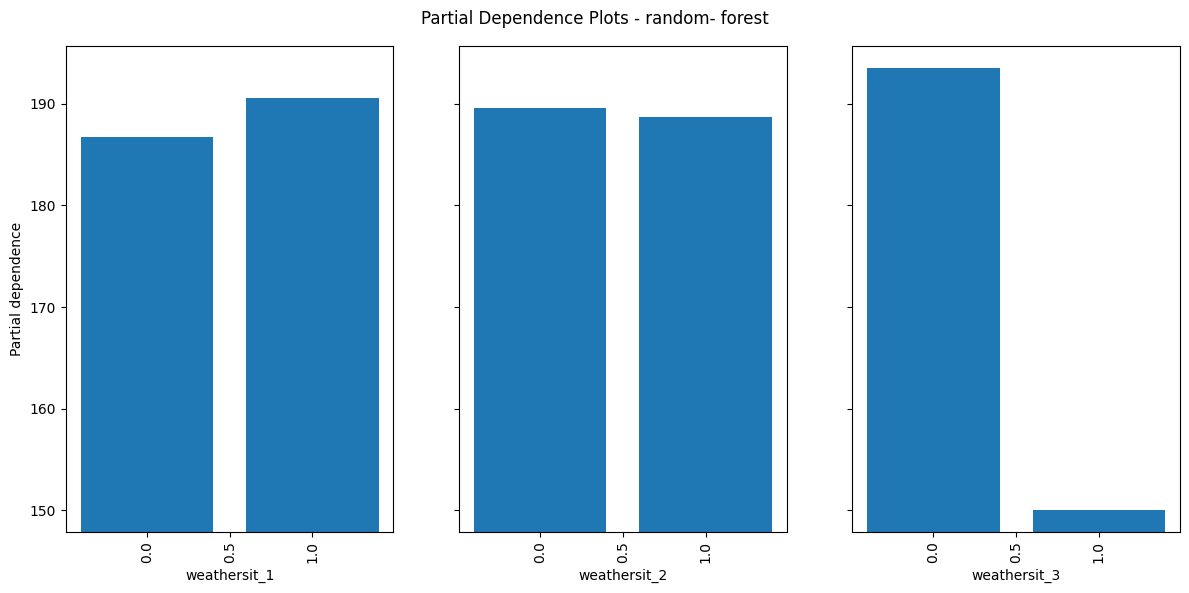

In [15]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["weathersit_1","weathersit_2","weathersit_3"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf, 
                                         X_train, 
                                         features,
                                         categorical_features=["weathersit_1","weathersit_2","weathersit_3"],
                                         kind="average",
                                         grid_resolution=50,
                                         ax = ax1,
                                         n_cols=4
                                         
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()


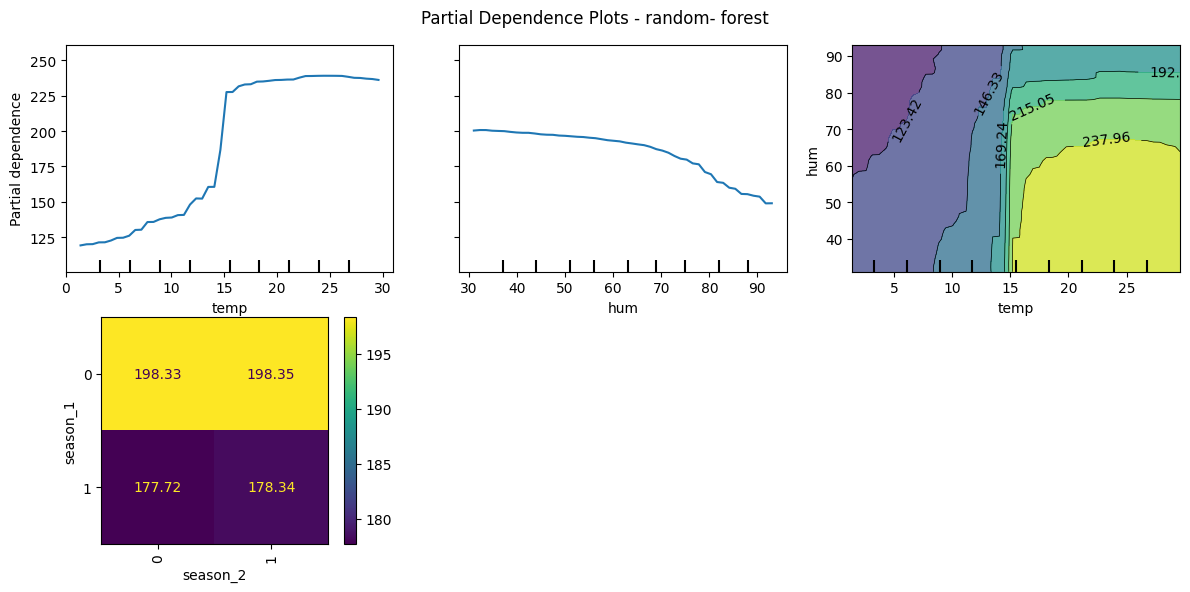

In [ ]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum",("temp","hum"),("season_1","season_2")]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf, 
                                         X_train, 
                                         features,
                                         categorical_features=["season_1","season_2"],
                                         kind="average",
                                         grid_resolution=50,
                                         ax = ax1
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()


### Accumulated local effect

In [17]:
rf_ale = ALE(rf.predict, feature_names=features_names, target_names=["bike sell"])

In [18]:
rf_exp = rf_ale.explain(X_train.to_numpy())

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fit

array([[<Axes: xlabel='temp', ylabel='ALE'>,
        <Axes: xlabel='hum', ylabel='ALE'>,
        <Axes: xlabel='windspeed', ylabel='ALE'>]], dtype=object)

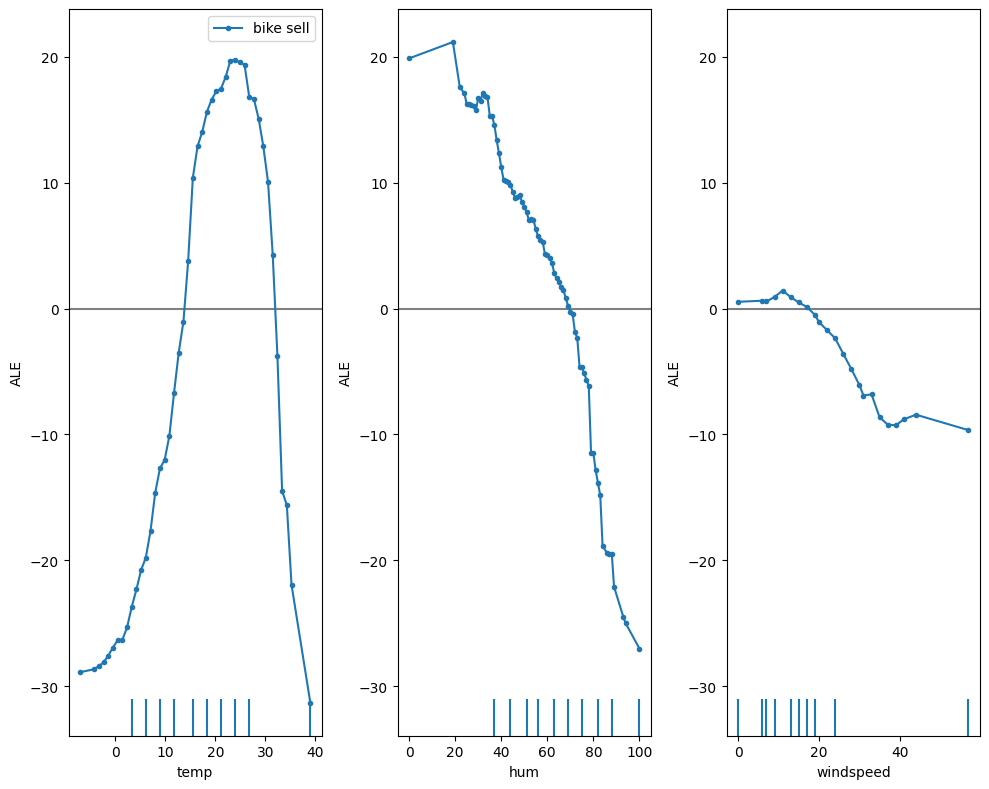

In [19]:
_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(rf_exp, features=["temp","hum","windspeed"], ax= ax1, targets=[0])

### Feature interaction with friedman statistic

In [20]:
random.seed(8)
X_exp = random.choices(X_train.to_numpy(), k=200)
X_exp = pd.DataFrame(X_exp, columns=features_names)

In [21]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(rf, X_exp, batchsize=20)

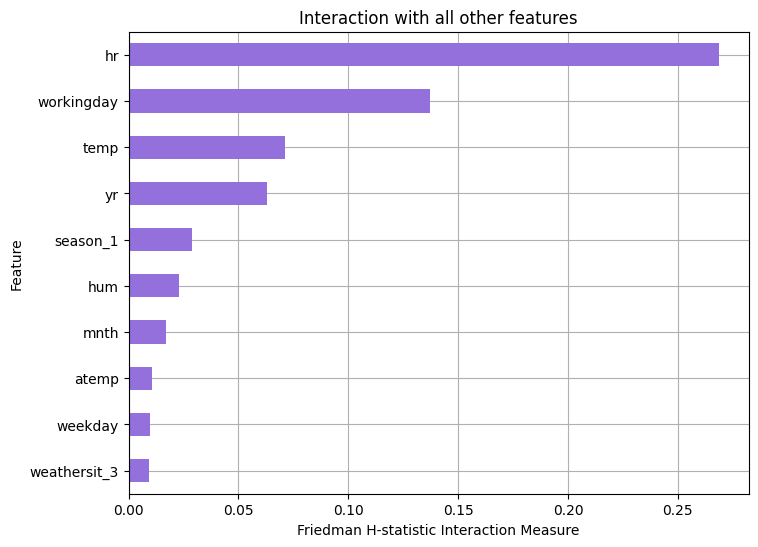

In [22]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )

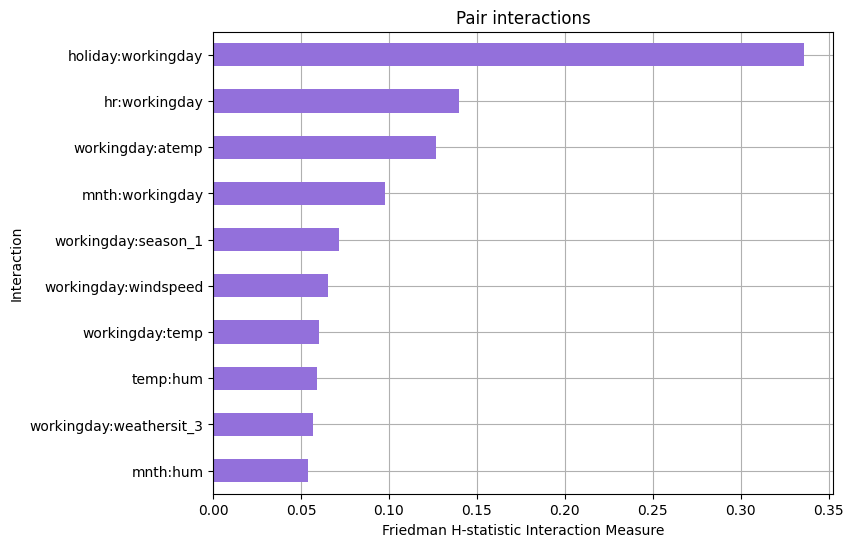

In [23]:
# Interaction One vs One
h_stat.plot(vis_type="bar_chart",top_k=10 )

Au vu des cette statistique l'interprétation weathersit_2 peut être compliquée car son effet joint avec season_2 explique 55% de sa contribution.
Son interprétation peut donc être fastidieuse


## Feature permutation importance

In [12]:
result = permutation_importance(rf, X_train, y_train,
                           n_repeats=15,
                           random_state=0
                           )


In [13]:
result.importances_mean

array([2.17397016e-01, 3.97535324e-02, 1.39493792e+00, 4.09532987e-03,
       2.68002141e-02, 3.04043368e-01, 1.63774407e-01, 2.73062827e-02,
       6.57925209e-02, 1.07270580e-02, 2.70511593e-02, 8.82226552e-04,
       8.14012153e-04, 1.11557773e-02, 2.29079840e-03, 9.60631570e-04,
       2.38694040e-02, 0.00000000e+00])

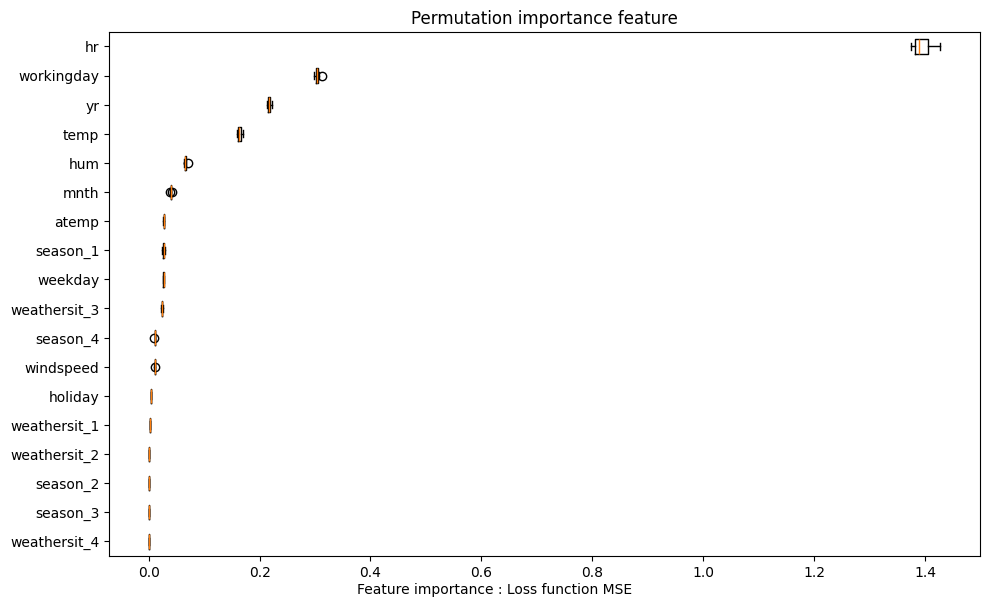

In [14]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function MSE", ha='center')

fig.tight_layout()
plt.show()

### Local model-agnostic

#### Individual Conditionnal Expectation (ICE)

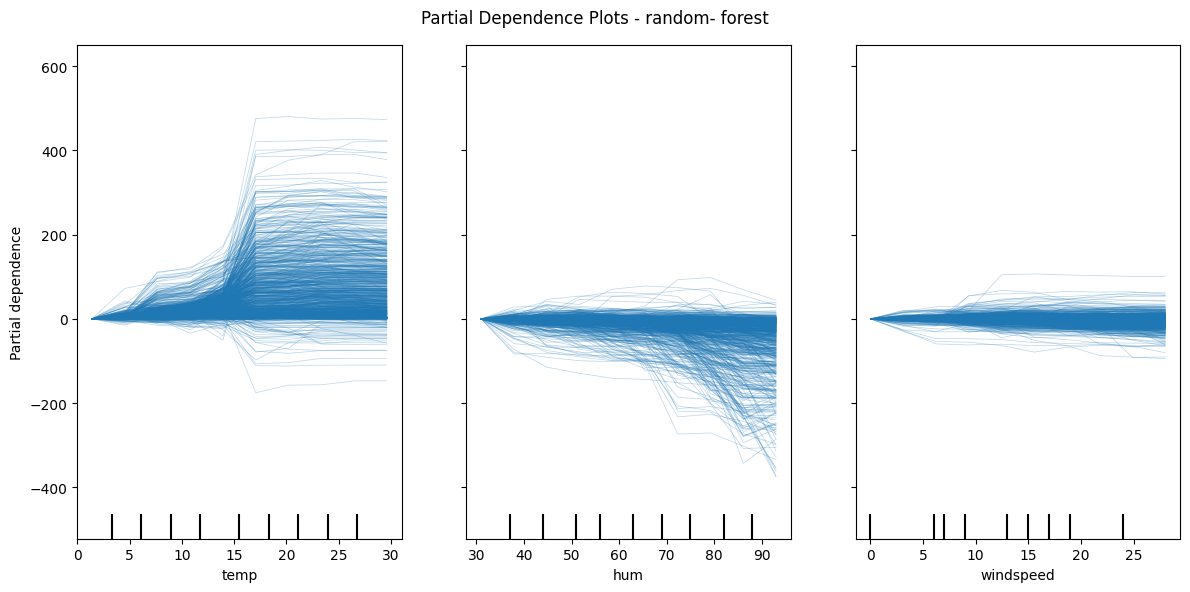

In [67]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum","windspeed"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="individual",
                                         ax = ax1,
                                         grid_resolution=10, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3,
                                         subsample=0.05, # 50% du jeu de données
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

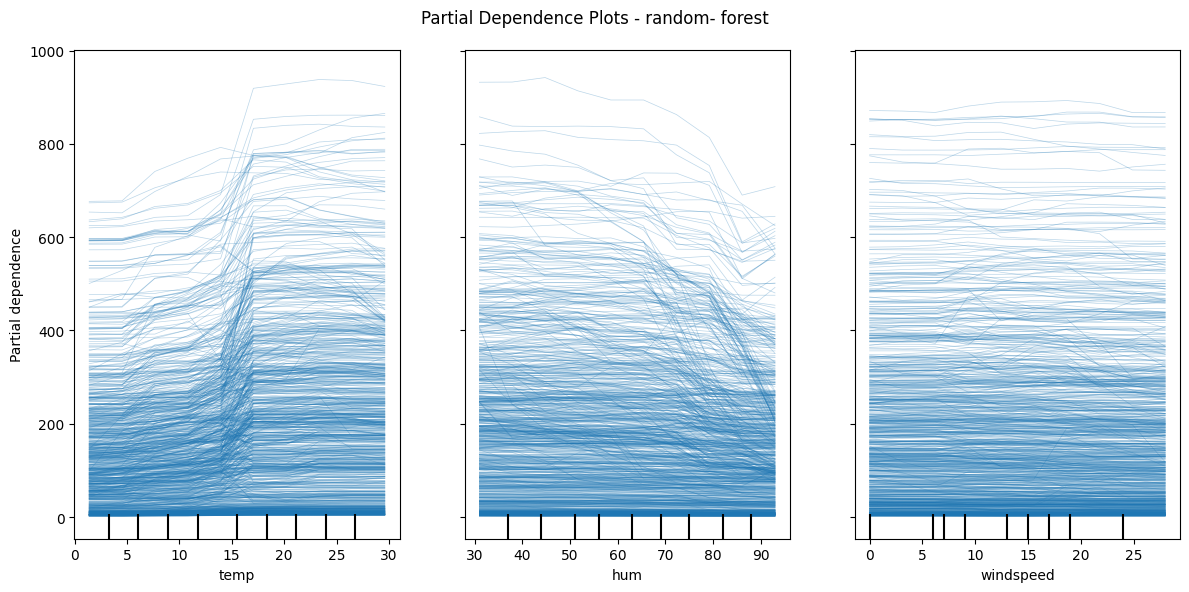

In [71]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum","windspeed"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="individual",
                                         ax = ax1,
                                         grid_resolution=10, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3,
                                         subsample=0.05, # 50% du jeu de données
                                         centered=False
                                         
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

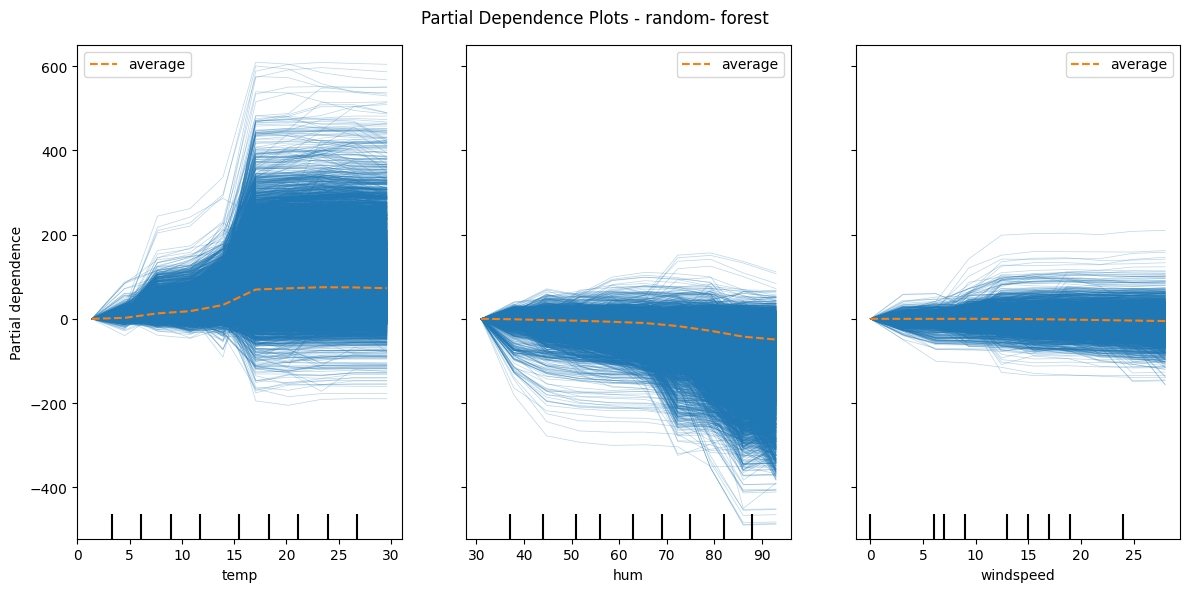

In [75]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["temp","hum","windspeed"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train, 
                                         features,
                                         kind="both",
                                         ax = ax1,
                                         grid_resolution=10, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3,
                                         subsample=0.95, # 50% du jeu de données
                                         centered=True,
                                         contour_kw={'alpha': 0.1}
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

### Local surrogate AKA LIME

In [77]:
import lime
import lime.lime_tabular

In [91]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), 
                                                   feature_names=features_names ,
                                                   class_names=['cnt']  ,
                                                   verbose=True,
                                                     mode='regression'
                                                     )

In [116]:
i = 3019
exp = explainer.explain_instance(X_train.loc[i], rf.predict, num_features=5)

c:\Users\roulB\Desktop\cours_iae\.my_test_env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 142.13060352876434
Prediction_local [288.78500121]
Right: 542.22


In [117]:
exp.show_in_notebook(show_table=True)

### Shapley values

In [14]:
import shap

In [15]:
predict_rf = rf.predict(X_train)


In [97]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train.iloc[1:300])

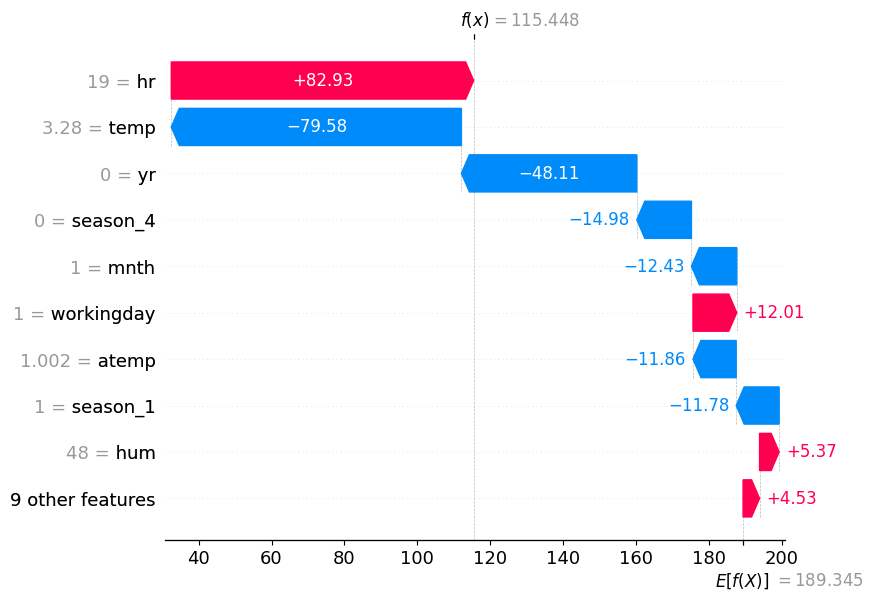

In [98]:
shap.initjs()
# visualize the first prediction's explanation
shap.waterfall_plot(shap_values[86])

In [89]:
shap.force_plot(shap_values[86])


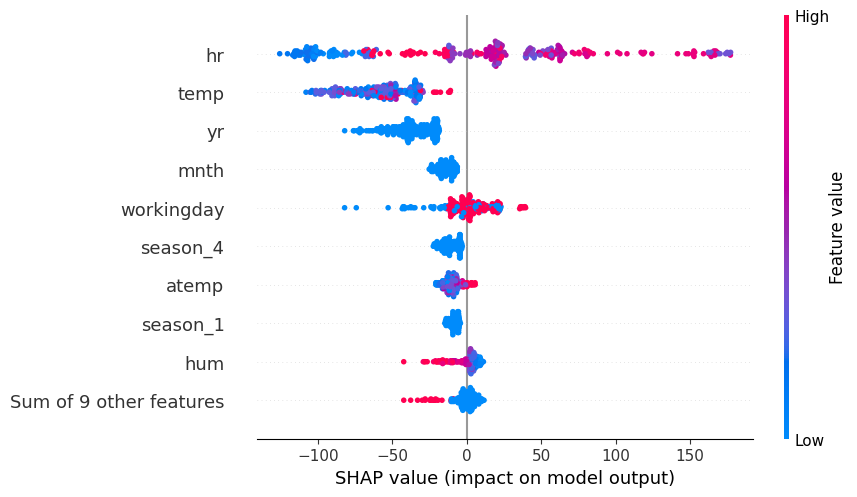

In [99]:
shap.plots.beeswarm(shap_values)

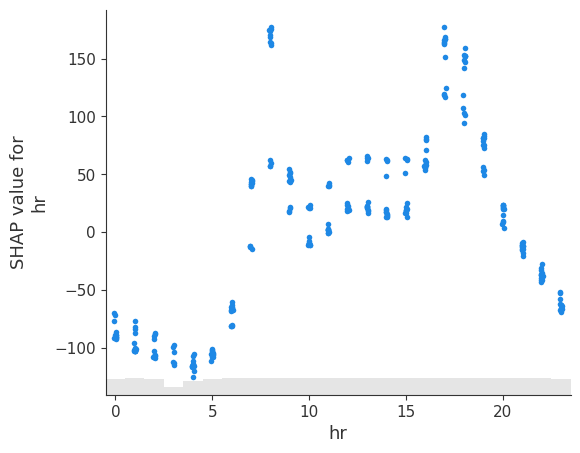

In [100]:
shap.plots.scatter(shap_values[:, 'hr'])


In [103]:
shap_values[1,:,1]

IndexError: too many indices for array

In [104]:
import shap
from sklearn.model_selection import train_test_split
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1
)



In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
# Define the categorical and numerical features
cats = ['Workclass', 'Marital Status', 'Occupation',
'Relationship', 'Race', 'Sex', 'Country']
nums = ['Age', 'Education-Num', 'Capital Gain',
'Capital Loss', 'Hours per week']
# Define the column transformer
preprocessor = ColumnTransformer(
transformers=[
('cat', OneHotEncoder(), cats),
('num', StandardScaler(), nums)
])
# Define the pipeline
model = Pipeline([
('preprocessor', preprocessor),
('classifier', LogisticRegression(max_iter=10000))
])

In [ ]:
# Fit the pipeline to the training data
model.fit(X_train, y_train)
X_sub = shap.sample(X_train, 100)



PermutationExplainer explainer: 101it [00:24,  3.02it/s]                         


In [108]:
X_sub

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
25189,51.0,4,10.0,0,4,0,4,0,0.0,0.0,36.0,39
14214,32.0,4,9.0,2,12,4,1,1,0.0,0.0,40.0,17
24963,20.0,4,10.0,4,8,3,4,1,0.0,0.0,50.0,39
18067,27.0,4,13.0,4,4,3,4,0,0.0,0.0,40.0,39
19293,51.0,4,9.0,5,1,2,4,0,0.0,0.0,40.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
14085,39.0,4,8.0,3,14,0,2,1,0.0,0.0,45.0,0
28468,50.0,4,5.0,2,3,4,4,1,2885.0,0.0,40.0,39
3482,27.0,4,9.0,0,12,1,4,0,0.0,0.0,37.0,39
2751,55.0,0,9.0,0,0,0,4,1,0.0,0.0,20.0,39


In [ ]:
ex = shap.Explainer(model.predict_proba, X_sub)
shap_values = ex(X_test.iloc[0:100])

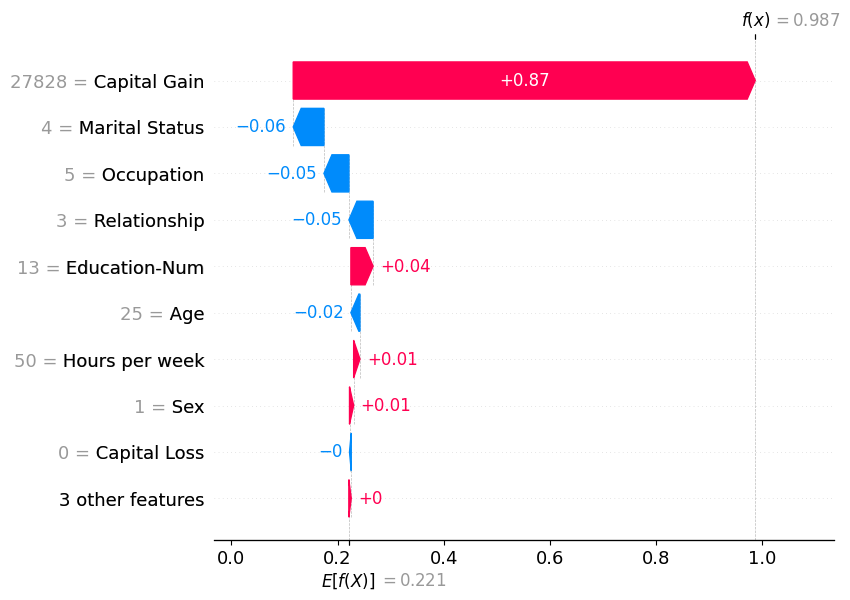

In [116]:
class_index = 1
data_index = 2
shap.plots.waterfall(shap_values[data_index,:,class_index])
